In [9]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from Heatmap_plot import Heatmap
from Training import GetDatasets
from Nets  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Simulation import buffer_simulation, save_obj, load_obj

tf.random.set_seed(1234)
np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Get Dataset

In [10]:
train_batch_size = test_batch_size = 32
train_set,valid_set,test_set = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, train_batch_size, test_batch_size)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Get Model

In [19]:
SqueezeNet     = GetNeuralNetworkModel('SqueezeNet',(224,224,3),8, quantization = False, aging_active=False)
loss      = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
SqueezeNet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [20]:
Indices = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
for index,layer in enumerate(SqueezeNet.layers):
    if index in Indices:
        print(index,layer.name, layer.output_shape)

0 input_4 [(None, 224, 224, 3)]
3 conv2d_78 (None, 112, 112, 96)
7 max_pooling2d_9 (None, 56, 56, 96)
9 conv2d_79 (None, 56, 56, 16)
20 conv2d_82 (None, 56, 56, 16)
31 conv2d_85 (None, 56, 56, 32)
42 max_pooling2d_10 (None, 28, 28, 256)
44 conv2d_88 (None, 28, 28, 32)
55 conv2d_91 (None, 28, 28, 48)
66 conv2d_94 (None, 28, 28, 48)
77 conv2d_97 (None, 28, 28, 64)
88 max_pooling2d_11 (None, 14, 14, 512)
90 conv2d_100 (None, 14, 14, 64)
101 conv2d_103 (None, 14, 14, 8)
104 global_average_pooling2d_3 (None, 8)


In [18]:
for index,layer in enumerate(SqueezeNet.layers):
    print(index,layer.name)

0 input_3 [(None, 224, 224, 3)]
1 lambda_86 (None, 224, 224, 3)
2 lambda_87 (None, 224, 224, 3)
3 conv2d_52 (None, 112, 112, 96)
4 re_lu_50 (None, 112, 112, 96)
5 lambda_88 (None, 112, 112, 96)
6 lambda_89 (None, 112, 112, 96)
7 max_pooling2d_6 (None, 56, 56, 96)
8 lambda_90 (None, 56, 56, 96)
9 conv2d_53 (None, 56, 56, 16)
10 re_lu_51 (None, 56, 56, 16)
11 lambda_91 (None, 56, 56, 16)
12 lambda_92 (None, 56, 56, 16)
13 conv2d_54 (None, 56, 56, 64)
14 conv2d_55 (None, 56, 56, 64)
15 re_lu_52 (None, 56, 56, 64)
16 re_lu_53 (None, 56, 56, 64)
17 concatenate_16 (None, 56, 56, 128)
18 lambda_93 (None, 56, 56, 128)
19 lambda_94 (None, 56, 56, 128)
20 conv2d_56 (None, 56, 56, 16)
21 re_lu_54 (None, 56, 56, 16)
22 lambda_95 (None, 56, 56, 16)
23 lambda_96 (None, 56, 56, 16)
24 conv2d_57 (None, 56, 56, 64)
25 conv2d_58 (None, 56, 56, 64)
26 re_lu_55 (None, 56, 56, 64)
27 re_lu_56 (None, 56, 56, 64)
28 concatenate_17 (None, 56, 56, 128)
29 lambda_97 (None, 56, 56, 128)
30 lambda_98 (None, 56, 5

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Training

In [40]:
(OrigLoss,OrigAcc) = SqueezeNet.evaluate(test_set)

24/24 [==============================] - 16s 645ms/step - loss: 2.0794 - accuracy: 0.1293


In [5]:
# Early Stopping
# --------------
#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
#    
#SqueezeNet.fit(x=trainSet,epochs=100,
#            steps_per_epoch  =int(np.ceil(trainSize / trainBatchSize)),
#            validation_data  =validSet,
#            validation_steps =int(np.ceil(validSize/ trainBatchSize)), 
#            callbacks=[earlyStop])

NameError: name 'trainSize' is not defined

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Load/Save Weigths

In [6]:
cwd = os.getcwd()
wgtDir = os.path.join(cwd, 'Data')
wgtDir = os.path.join(wgtDir, 'Trained Weights')
wgtDir = os.path.join(wgtDir, 'SqueezeNet')
wgtDir = os.path.join(wgtDir, 'Colorectal Dataset')
wgtDir = os.path.join(wgtDir,'Weights')
SqueezeNet.load_weights(wgtDir)

# 2) Stats

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  e) Activation Stats

In [8]:
ActivationStats(SqueezeNet,test_set,9,6,24)

mean value (MMU): -0.15221779
mean value (Buffer): 0.1397393
maximum (MMU): 108.66656
minimum (MMU): -181.97092
maximum (Buffer): 108.66656
minimum (Buffer): -132.98305
saturation ratio (MMU): 2.1723126783113452e-05
saturation ratio (Buffer): 1.7026719987814132e-06


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  f) Write/Read Stats

In [23]:
SqueezeNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
lambda_129 (Lambda)             (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
lambda_130 (Lambda)             (None, 224, 224, 3)  0           lambda_129[0][0]                 
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 112, 112, 96) 14208       lambda_130[0][0]                 
____________________________________________________________________________________________

In [5]:

Indices = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
Data    = GetReadAndWrites(SqueezeNet,Indices,801816,150,CNN_gating=False,network_name='SqueezeNet')
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(SqueezeNet,Indices,1024*1024,150,CNN_gating=True,network_name='SqueezeNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
CNN_gating_Acceses = pd.DataFrame(stats).reset_index(drop=False)
save_obj(Baseline_Acceses,'Data/Acceses/SqueezeNet/Baseline_v2')
save_obj(CNN_gating_Acceses,'Data/Acceses/SqueezeNet/CNN_gating_Fix_v2')

procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150
procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150


# 3) Quantization 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [33]:
CheckAccuracyAndLoss('SqueezeNet', testSet, wgt_dir=16, act_frac_size = 16, act_int_size = 16, wgt_frac_size = 16, wgt_int_size = 16, 
                    input_shape = (224,224,3), output_shape = 8, batch_size = test_batch_size);



NameError: name 'test_batch_size' is not defined

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Number of bits analysis

In [5]:
df = QuantizationEffect('SqueezeNet',testSet,wgtDir,(224,224,3),8,testBatchSize)
save_obj(df,'Data/Quantization/SqueezeNet/Colorectal Dataset/Quantization')

Activation fraction part
0  bits results:  acc:  0.218666672706604 loss:  nan
1  bits results:  acc:  0.4333333373069763 loss:  8.287890434265137
2  bits results:  acc:  0.6653333306312561 loss:  3.100663423538208
3  bits results:  acc:  0.8306666612625122 loss:  1.391799807548523
4  bits results:  acc:  0.9306666851043701 loss:  0.48411908745765686
5  bits results:  acc:  0.9279999732971191 loss:  0.39407071471214294
6  bits results:  acc:  0.9306666851043701 loss:  0.3379450738430023
7  bits results:  acc:  0.9306666851043701 loss:  0.2939336597919464
8  bits results:  acc:  0.9293333292007446 loss:  0.26737505197525024
9  bits results:  acc:  0.9319999814033508 loss:  0.2536109685897827
10  bits results:  acc:  0.9319999814033508 loss:  0.25389185547828674
11  bits results:  acc:  0.9319999814033508 loss:  0.24309079349040985
12  bits results:  acc:  0.9319999814033508 loss:  0.24374106526374817
13  bits results:  acc:  0.9319999814033508 loss:  0.24324987828731537
14  bits results:

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Used Config

In [5]:
CheckAccuracyAndLoss('SqueezeNet', testSet, wgtDir, aFracSize = 9, aIntSize = 6, wFracSize = 15, wIntSize = 0, 
                    inputShape = (224,224,3), outputShape = 8, batchSize = testBatchSize);

24/24 [==============================] - 4s 49ms/step - loss: 0.2536 - accuracy: 0.9307


# 3) Buffer Simulation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Baseline

In [10]:
Buffer  = load_obj('Data/Stats/VGG16/Colorectal Dataset/Baseline/Buffer')
ciclos  = load_obj('Data/Stats/VGG16/Colorectal Dataset/Baseline/cycles')

In [3]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

QSqueezeNet  = GetNeuralNetworkModel('SqueezeNet',(224,224,3),8, quantization = True, aging=False, wordSize = 16, fracSize = 9)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
QSqueezeNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QSqueezeNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QSqueezeNet, fracBits = 15, intBits = 0)


LI = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
AI = [2,6,8,12,     19,23,     30,34,     41,43,47,     54,58,     65,69,     76,80 ,    87,89,93,    100,103,107]
buffer_simulation(QSqueezeNet,testSet, integer_bits = 6, fractional_bits = 9, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/SqueezeNet/Colorectal Dataset/CNN-Gated/Adjusted Buffer/', buffer_size = 2*1204224,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 150528, 301056, 451584, 602112, 752640, 903168, 1053696, 1204224]
Simulation Started, time: 02:14:57 cycles:  0 offset:  0
procesed images: 0  time: 02:18:25 cycles:  1453369 offset:  150528
procesed images: 1  time: 02:21:59 cycles:  2906738 offset:  301056
procesed images: 2  time: 02:25:22 cycles:  4360107 offset:  451584
procesed images: 3  time: 02:28:56 cycles:  5813476 offset:  602112
procesed images: 4  time: 02:32:19 cycles:  7266845 offset:  752640
procesed images: 5  time: 02:35:53 cycles:  8720214 offset:  903168
procesed images: 6  time: 02:39:15 cycles:  10173583 offset:  1053696
procesed images: 7  time: 02:42:49 cycles:  11626952 offset:  1204224
procesed images: 8  time: 02:46:11 cycles:  13080321 offset:  150528
procesed images: 9  time: 02:49:44 cycles:  14533690 offset:  301056
procesed images: 10  time: 02:53:07 cycles:  15987059 offset:  451584
procesed images: 11  time: 02:56:40 cycles:  17440428 offset:  602112
procesed images: 12  time: 03

procesed images: 114  time: 08:53:58 cycles:  167137435 offset:  451584
procesed images: 115  time: 08:57:32 cycles:  168590804 offset:  602112
procesed images: 116  time: 09:00:54 cycles:  170044173 offset:  752640
procesed images: 117  time: 09:04:27 cycles:  171497542 offset:  903168
procesed images: 118  time: 09:07:51 cycles:  172950911 offset:  1053696
procesed images: 119  time: 09:11:24 cycles:  174404280 offset:  1204224
procesed images: 120  time: 09:14:48 cycles:  175857649 offset:  150528
procesed images: 121  time: 09:18:21 cycles:  177311018 offset:  301056
procesed images: 122  time: 09:21:44 cycles:  178764387 offset:  451584
procesed images: 123  time: 09:25:18 cycles:  180217756 offset:  602112
procesed images: 124  time: 09:28:41 cycles:  181671125 offset:  752640
procesed images: 125  time: 09:32:14 cycles:  183124494 offset:  903168
procesed images: 126  time: 09:35:37 cycles:  184577863 offset:  1053696
procesed images: 127  time: 09:39:10 cycles:  186031232 offse

({'Number of Addresses': 1204224,
  'Data': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
  'HighCyclesCount': array([ 1886241,  1922355,  2368836, ..., 24256865, 25447730, 24919589],
        dtype=uint32),
  'OffCyclesCount': array([160823627, 160823627, 160823627, ..., 162481105, 162481105,
         162481105], dtype=uint32),
  'LowCyclesCount': array([55295482, 55259368, 54812887, ..., 31267380, 30076515, 30604656],
        dtype=uint32),
  'Flips': array([223, 223, 231, ..., 147, 145, 152], dtype=uint32),
  'offset': 903168},
 218005350)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; CNN-Gated, case 2

In [4]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

QSqueezeNet  = GetNeuralNetworkModel('SqueezeNet',(224,224,3),8, quantization = True, aging=False, wordSize = 16, fracSize = 9)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
QSqueezeNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QSqueezeNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QSqueezeNet, fracBits = 15, intBits = 0)


LI = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
AI = [2,6,8,12,     19,23,     30,34,     41,43,47,     54,58,     65,69,     76,80 ,    87,89,93,    100,103,107]
buffer_simulation(QSqueezeNet,testSet, integer_bits = 6, fractional_bits = 9, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/SqueezeNet/Colorectal Dataset/CNN-Gated/', buffer_size = 2*1024*1024,
                 layer_indexes = LI , activation_indixes = AI)

Buffer sections:  [0, 131072, 262144, 393216, 524288, 655360, 786432, 917504, 1048576]
Simulation Started, time: 21:54:35 cycles:  156963852 offset:  524288
--now processing CPULayer input_1
----layer size:  150528
------Current Address:  524288
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:01:01
--now processing: Conv conv2d
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d
----layer size:  301056
------Current Address:  786432
------Wrap:  True
------End Address:  131072
----elapsed layer simulation time:  0:03:42
--now processing: Conv conv2d_1
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_2 conv2d_3
----layer size:  401408
------Current Address:  131072
------Wrap:  False
------End Address:  393216
------Current Address:  393216
------Wrap:  False
------End Address:  655360
----elapsed layer simulation time:  0:00:26
--now processing: Conv conv2d_4
----Skiped due to unninsterested buffer
-

------End Address:  393216
----elapsed layer simulation time:  0:01:05
--now processing CPULayer max_pooling2d_1
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_10
----layer size:  25088
------Current Address:  393216
------Wrap:  False
------End Address:  524288
----elapsed layer simulation time:  0:00:01
--now processing: Expand conv2d_11 conv2d_12
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_13
----layer size:  37632
------Current Address:  524288
------Wrap:  False
------End Address:  655360
----elapsed layer simulation time:  0:00:01
--now processing: Expand conv2d_14 conv2d_15
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_16
----layer size:  37632
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:01
--now processing: Expand conv2d_17 conv2d_18
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_19
----layer size:  50176
-----

------End Address:  393216
------Current Address:  393216
------Wrap:  False
------End Address:  524288
----elapsed layer simulation time:  0:00:04
--now processing: Conv conv2d_25
----Skiped due to unninsterested buffer
--now processing CPULayer global_average_pooling2d
----layer size:  8
------Current Address:  524288
------Wrap:  False
------End Address:  655360
----elapsed layer simulation time:  0:00:00
procesed images: 112  time: 22:22:50 cycles:  164230697 offset:  655360
--now processing CPULayer input_1
----Skiped due to unninsterested buffer
--now processing: Conv conv2d
----layer size:  1204224
----Bypassed
--now processing CPULayer max_pooling2d
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_1
----layer size:  50176
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:02
--now processing: Expand conv2d_2 conv2d_3
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_4
---

------End Address:  524288
----elapsed layer simulation time:  0:01:42
--now processing: Conv conv2d_10
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_11 conv2d_12
----layer size:  200704
------Current Address:  524288
------Wrap:  False
------End Address:  655360
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:10
--now processing: Conv conv2d_13
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_14 conv2d_15
----layer size:  301056
------Current Address:  786432
------Wrap:  False
------End Address:  1048576
------Current Address:  1048576
------Wrap:  True
------End Address:  262144
----elapsed layer simulation time:  0:00:16
--now processing: Conv conv2d_16
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_17 conv2d_18
----layer size:  301056
------Current Address:  262144
------Wrap:  False
------End Address:  524288
------Current Address:  52428

------End Address:  655360
----elapsed layer simulation time:  0:00:00
--now processing: Expand conv2d_23 conv2d_24
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_25
----layer size:  1568
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:00
--now processing CPULayer global_average_pooling2d
----Skiped due to unninsterested buffer
procesed images: 117  time: 22:46:46 cycles:  171497542 offset:  786432
--now processing CPULayer input_1
----layer size:  150528
------Current Address:  786432
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:01:00
--now processing: Conv conv2d
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d
----layer size:  301056
------Current Address:  1048576
------Wrap:  True
------End Address:  393216
----elapsed layer simulation time:  0:03:42
--now processing: Conv conv2d_1
----Skiped due to unninsterested buffe

------End Address:  655360
----elapsed layer simulation time:  0:00:27
--now processing: Conv conv2d_7
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_8 conv2d_9
----layer size:  802816
------Current Address:  655360
------Wrap:  True
------End Address:  131072
------Current Address:  131072
------Wrap:  False
------End Address:  655360
----elapsed layer simulation time:  0:01:08
--now processing CPULayer max_pooling2d_1
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_10
----layer size:  25088
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:01
--now processing: Expand conv2d_11 conv2d_12
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_13
----layer size:  37632
------Current Address:  786432
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:00:01
--now processing: Expand conv2d_14 conv2d_15
----Skiped due to unninster

------Wrap:  False
------End Address:  524288
----elapsed layer simulation time:  0:00:31
--now processing: Conv conv2d_22
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_23 conv2d_24
----layer size:  100352
------Current Address:  524288
------Wrap:  False
------End Address:  655360
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:04
--now processing: Conv conv2d_25
----Skiped due to unninsterested buffer
--now processing CPULayer global_average_pooling2d
----layer size:  8
------Current Address:  786432
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:00:00
procesed images: 122  time: 23:15:57 cycles:  178764387 offset:  917504
--now processing CPULayer input_1
----Skiped due to unninsterested buffer
--now processing: Conv conv2d
----layer size:  1204224
----Bypassed
--now processing CPULayer max_pooling2d
----Skiped due to unninsterested buffer
--now proces

------Wrap:  False
------End Address:  524288
----elapsed layer simulation time:  0:00:05
--now processing: Expand conv2d_8 conv2d_9
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d_1
----layer size:  200704
------Current Address:  524288
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:01:49
--now processing: Conv conv2d_10
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_11 conv2d_12
----layer size:  200704
------Current Address:  786432
------Wrap:  False
------End Address:  917504
------Current Address:  917504
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00:10
--now processing: Conv conv2d_13
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_14 conv2d_15
----layer size:  301056
------Current Address:  1048576
------Wrap:  True
------End Address:  262144
------Current Address:  262144
------Wrap:  False
------End Address:  524288
---

------End Address:  524288
------Current Address:  524288
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:23
--now processing CPULayer max_pooling2d_2
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_22
----layer size:  12544
------Current Address:  786432
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:00:00
--now processing: Expand conv2d_23 conv2d_24
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_25
----layer size:  1568
------Current Address:  917504
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00:00
--now processing CPULayer global_average_pooling2d
----Skiped due to unninsterested buffer
procesed images: 127  time: 23:40:38 cycles:  186031232 offset:  1048576
--now processing CPULayer input_1
----layer size:  150528
------Current Address:  1048576
------Wrap:  True
------End Address:  262144
----elapsed layer simulation tim

------End Address:  393216
----elapsed layer simulation time:  0:00:26
--now processing: Conv conv2d_4
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_5 conv2d_6
----layer size:  401408
------Current Address:  393216
------Wrap:  False
------End Address:  655360
------Current Address:  655360
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:00:26
--now processing: Conv conv2d_7
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_8 conv2d_9
----layer size:  802816
------Current Address:  917504
------Wrap:  True
------End Address:  393216
------Current Address:  393216
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:01:05
--now processing CPULayer max_pooling2d_1
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_10
----layer size:  25088
------Current Address:  917504
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00

------Wrap:  False
------End Address:  655360
----elapsed layer simulation time:  0:00:02
--now processing: Expand conv2d_20 conv2d_21
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d_2
----layer size:  100352
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:29
--now processing: Conv conv2d_22
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_23 conv2d_24
----layer size:  100352
------Current Address:  786432
------Wrap:  False
------End Address:  917504
------Current Address:  917504
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00:04
--now processing: Conv conv2d_25
----Skiped due to unninsterested buffer
--now processing CPULayer global_average_pooling2d
----layer size:  8
------Current Address:  1048576
------Wrap:  True
------End Address:  131072
----elapsed layer simulation time:  0:00:00
procesed images: 132  time: 00:09

------End Address:  655360
----elapsed layer simulation time:  0:00:02
--now processing: Expand conv2d_5 conv2d_6
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_7
----layer size:  100352
------Current Address:  655360
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:05
--now processing: Expand conv2d_8 conv2d_9
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d_1
----layer size:  200704
------Current Address:  786432
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:01:44
--now processing: Conv conv2d_10
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_11 conv2d_12
----layer size:  200704
------Current Address:  1048576
------Wrap:  True
------End Address:  131072
------Current Address:  131072
------Wrap:  False
------End Address:  262144
----elapsed layer simulation time:  0:00:10
--now processing: Conv conv2d_13
----Skiped due to unninst

------End Address:  524288
----elapsed layer simulation time:  0:00:16
--now processing: Conv conv2d_19
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_20 conv2d_21
----layer size:  401408
------Current Address:  524288
------Wrap:  False
------End Address:  786432
------Current Address:  786432
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00:23
--now processing CPULayer max_pooling2d_2
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_22
----layer size:  12544
------Current Address:  1048576
------Wrap:  True
------End Address:  131072
----elapsed layer simulation time:  0:00:00
--now processing: Expand conv2d_23 conv2d_24
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_25
----layer size:  1568
------Current Address:  131072
------Wrap:  False
------End Address:  262144
----elapsed layer simulation time:  0:00:00
--now processing CPULayer global_average_pooling2d
----Skiped due to

------Wrap:  False
------End Address:  393216
------Current Address:  393216
------Wrap:  False
------End Address:  655360
----elapsed layer simulation time:  0:00:26
--now processing: Conv conv2d_4
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_5 conv2d_6
----layer size:  401408
------Current Address:  655360
------Wrap:  False
------End Address:  917504
------Current Address:  917504
------Wrap:  True
------End Address:  131072
----elapsed layer simulation time:  0:00:26
--now processing: Conv conv2d_7
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_8 conv2d_9
----layer size:  802816
------Current Address:  131072
------Wrap:  False
------End Address:  655360
------Current Address:  655360
------Wrap:  True
------End Address:  131072
----elapsed layer simulation time:  0:01:05
--now processing CPULayer max_pooling2d_1
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_10
----layer size:  25088
------Current Address: 

------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:01
--now processing: Expand conv2d_17 conv2d_18
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_19
----layer size:  50176
------Current Address:  786432
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:00:02
--now processing: Expand conv2d_20 conv2d_21
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d_2
----layer size:  100352
------Current Address:  917504
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00:33
--now processing: Conv conv2d_22
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_23 conv2d_24
----layer size:  100352
------Current Address:  1048576
------Wrap:  True
------End Address:  131072
------Current Address:  131072
------Wrap:  False
------End Address:  262144
----elapsed layer simulation time:  0:00:04
--now processing: Conv conv2d_25
--

------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:03
--now processing: Expand conv2d_2 conv2d_3
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_4
----layer size:  50176
------Current Address:  786432
------Wrap:  False
------End Address:  917504
----elapsed layer simulation time:  0:00:03
--now processing: Expand conv2d_5 conv2d_6
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_7
----layer size:  100352
------Current Address:  917504
------Wrap:  False
------End Address:  1048576
----elapsed layer simulation time:  0:00:06
--now processing: Expand conv2d_8 conv2d_9
----Skiped due to unninsterested buffer
--now processing CPULayer max_pooling2d_1
----layer size:  200704
------Current Address:  1048576
------Wrap:  True
------End Address:  262144
----elapsed layer simulation time:  0:02:14
--now processing: Conv conv2d_10
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_11 conv2d_12
--

------Wrap:  False
------End Address:  524288
------Current Address:  524288
------Wrap:  False
------End Address:  786432
----elapsed layer simulation time:  0:00:18
--now processing: Conv conv2d_19
----Skiped due to unninsterested buffer
--now processing: Expand conv2d_20 conv2d_21
----layer size:  401408
------Current Address:  786432
------Wrap:  False
------End Address:  1048576
------Current Address:  1048576
------Wrap:  True
------End Address:  262144
----elapsed layer simulation time:  0:00:27
--now processing CPULayer max_pooling2d_2
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_22
----layer size:  12544
------Current Address:  262144
------Wrap:  False
------End Address:  393216
----elapsed layer simulation time:  0:00:00
--now processing: Expand conv2d_23 conv2d_24
----Skiped due to unninsterested buffer
--now processing: Conv conv2d_25
----layer size:  1568
------Current Address:  393216
------Wrap:  False
------End Address:  524288
----elapsed laye

({'Number of Addresses': 1048576,
  'Data': array([2, 2, 2, ..., 2, 2, 2]),
  'HighCyclesCount': array([  889874,   835777,  1127918, ..., 19739948, 22382819, 20493408],
        dtype=uint32),
  'OffCyclesCount': array([177651092, 177651092, 177651092, ..., 175232759, 175232759,
         175232759], dtype=uint32),
  'LowCyclesCount': array([39464384, 39518481, 39226340, ..., 23032643, 20389772, 22279183],
        dtype=uint32),
  'Flips': array([232, 227, 248, ...,  75,  88,  90], dtype=uint32),
  'offset': 786432},
 218005350)

In [73]:
np.put(a,range(0,13),b+1,mode='wrap')
a

array([3, 4, 5, 6, 7, 8])

# 4) Error Injection

In [6]:
trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

In [14]:
from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools

Start_from_zero = True

if Start_from_zero:
    Accs     = {0.00001:[],0.00005:[],0.0001:[]}
    Loss     = {0.00001:[],0.00005:[],0.0001:[]}
else:
    Accs     = load_obj('Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/Accs')
    Loss     = load_obj('Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/Loss')

network_size   = 1204224*16
num_of_samples = 200
for Enumber in Accs:
    n_bits_fails = np.ceil(Enumber*network_size).astype(int)
    errors       = np.random.randint(0,2,n_bits_fails)
    buffer       = np.array(['x']*(network_size-n_bits_fails))
    buffer_with_errors = np.concatenate([buffer,errors])
    for index in range(0,num_of_samples):
        np.random.shuffle(buffer_with_errors)
        address_with_errors = np.reshape(buffer_with_errors,(-1,16))
        address_with_errors = ["".join(i) for i in address_with_errors]
        error_mask = [y for x
                      ,y in enumerate(address_with_errors) if y.count('x') < 16]
        locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        loss,acc   = CheckAccuracyAndLoss('SqueezeNet', test_dataset, wgtDir, outputShape=8, inputShape = (224,224,3),
                                            aFracSize = 9, aIntSize = 6, wFracSize = 15, wIntSize = 0,
                                            batchSize=testBatchSize, verbose = 0, aging = True,
                                            faultyAddresses = locs, maskedFaults = error_mask)
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    save_obj(Accs,'Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/Accs')
    save_obj(Loss,'Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/Loss')

1e-05 completada:  05:38:12
5e-05 completada:  06:15:48
0.0001 completada:  06:56:20


In [7]:
from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools

Start_from_zero = True

if Start_from_zero:
    Accs     = {0.00001:[],0.00005:[],0.0001:[]}
    Loss     = {0.00001:[],0.00005:[],0.0001:[]}
else:
    Accs     = load_obj('Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/weights Accs')
    Loss     = load_obj('Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/weights Loss')

    
network_size   = 147712*16
num_of_samples = 200
for Enumber in Accs:
    n_bits_fails = np.ceil(Enumber*1204224).astype(int)
    errors       = np.random.randint(0,2,n_bits_fails)
    buffer       = np.array(['x']*(network_size-n_bits_fails))
    buffer       = np.concatenate([buffer,errors])
    for index in range(0,num_of_samples):
        np.random.shuffle(buffer)
        address_with_errors = np.reshape(buffer,(-1,16))
        address_with_errors = ["".join(i) for i in address_with_errors]
        error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        del address_with_errors
        loss,acc   = CheckAccuracyAndLoss('SqueezeNet', test_dataset, wgtDir, outputShape=8, inputShape = (224,224,3),
                                            aFracSize = 9, aIntSize = 6, wFracSize = 15, wIntSize = 0,
                                            batchSize=testBatchSize, verbose = 0, aging = False, WeightsFaults = True,
                                            faultyAddresses = locs, maskedFaults = error_mask)
        print(index,' completados: ', datetime.now().strftime("%H:%M:%S"))
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    save_obj(Accs,'Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/weights Accs')
    save_obj(Loss,'Data/Errors/SqueezeNet/Colorectal Dataset/Uniform distribution/weights Loss')

0  completados:  19:39:38
1  completados:  19:39:42
2  completados:  19:39:46
3  completados:  19:39:50
4  completados:  19:39:54
5  completados:  19:39:57
6  completados:  19:40:00
7  completados:  19:40:03
8  completados:  19:40:06
9  completados:  19:40:09
10  completados:  19:40:13
11  completados:  19:40:16
12  completados:  19:40:20
13  completados:  19:40:24
14  completados:  19:40:29
15  completados:  19:40:33
16  completados:  19:40:37
17  completados:  19:40:41
18  completados:  19:40:45
19  completados:  19:40:49
20  completados:  19:40:53
21  completados:  19:40:57
22  completados:  19:41:01
23  completados:  19:41:04
24  completados:  19:41:08
25  completados:  19:41:12
26  completados:  19:41:16
27  completados:  19:41:20
28  completados:  19:41:24
29  completados:  19:41:28
30  completados:  19:41:31
31  completados:  19:41:34
32  completados:  19:41:38
33  completados:  19:41:42
34  completados:  19:41:46
35  completados:  19:41:49
36  completados:  19:41:53
37  complet

100  completados:  19:59:01
101  completados:  19:59:06
102  completados:  19:59:10
103  completados:  19:59:14
104  completados:  19:59:18
105  completados:  19:59:22
106  completados:  19:59:26
107  completados:  19:59:31
108  completados:  19:59:35
109  completados:  19:59:39
110  completados:  19:59:43
111  completados:  19:59:47
112  completados:  19:59:52
113  completados:  19:59:56
114  completados:  20:00:00
115  completados:  20:00:03
116  completados:  20:00:07
117  completados:  20:00:11
118  completados:  20:00:15
119  completados:  20:00:19
120  completados:  20:00:22
121  completados:  20:00:26
122  completados:  20:00:30
123  completados:  20:00:34
124  completados:  20:00:38
125  completados:  20:00:42
126  completados:  20:00:46
127  completados:  20:00:50
128  completados:  20:00:54
129  completados:  20:00:58
130  completados:  20:01:02
131  completados:  20:01:05
132  completados:  20:01:09
133  completados:  20:01:13
134  completados:  20:01:17
135  completados:  2

196  completados:  20:18:55
197  completados:  20:18:59
198  completados:  20:19:03
199  completados:  20:19:06
0.0001 completada:  20:19:06


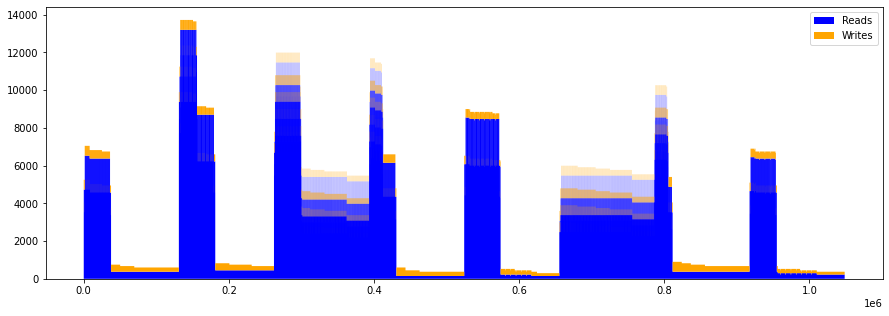

In [8]:
plt.figure(figsize=(15, 5))
plt.stackplot(CNN_gating_Acceses.to_dict()['index'].values(),
              CNN_gating_Acceses.to_dict()['Lecturas'].values(),
              CNN_gating_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])